<a href="https://colab.research.google.com/github/gvidas333/GMM/blob/main/2Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Import necessary libraries
!pip install openimages

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from openimages.download import download_dataset
import requests
import json
import io
import base64
from IPython.display import display, HTML

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 7.1 MB/s eta 0:00:00
Using device: cuda


In [ ]:
# Cell 2: Download images from OpenImages dataset
data_dir = "data"
classes = ["Bee", "Balloon", "Orange"]
number_for_samples = 334

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

def download_images():
    print("Downloading is starting...")
    download_dataset(data_dir, classes, limit=number_for_samples)

download_images()

100%|██████████| 334/334 [00:08<00:00, 37.43it/s]


In [ ]:
# Cell 3: Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a smaller size for custom CNN
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Cell 4: Create custom Dataset class
class ImageClassificationDataset(Dataset):
    def __init__(self, data_dir, classes, transform=None):
        """Initialize the dataset with root directory and transformation
        Args:
            data_dir (str): Root directory of images
            classes (list): List of class names
            transform: Optional transform to be applied on images
        """
        self.data_dir = data_dir
        self.classes = classes
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # For each class, find all images and add them to our dataset
        for class_idx, class_name in enumerate(classes):
            class_path = os.path.join(data_dir, class_name.lower(), "images")
            if os.path.exists(class_path):
                class_images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.jpg')]
                self.image_paths.extend(class_images)
                self.labels.extend([class_idx] * len(class_images))

        print(f"Found {len(self.image_paths)} images total")
        for class_idx, class_name in enumerate(classes):
            class_count = self.labels.count(class_idx)
            print(f"Class {class_name}: {class_count} images")

    def __len__(self):
        """Return the total number of images"""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Load and return a sample from the dataset
        Args:
            idx (int): Index of the sample to load
        Returns:
            tuple: (image, label) where label is the class index
        """
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Cell 5: Load dataset and create train/test split
dataset = ImageClassificationDataset(data_dir, classes, transform=transform)

# Split into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Found 1002 images total
Class Bee: 334 images
Class Balloon: 334 images
Class Orange: 334 images
Training set size: 801
Testing set size: 201


In [ ]:
# Cell 6: Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
#Cell 7: Create a custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # After 4 pooling operations, the image size is reduced to 128/2^4 = 8
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Activation functions
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional blocks
        x = self.pool(self.relu(self.conv1(x)))  # 128x128 -> 64x64
        x = self.pool(self.relu(self.conv2(x)))  # 64x64 -> 32x32
        x = self.pool(self.relu(self.conv3(x)))  # 32x32 -> 16x16
        x = self.pool(self.relu(self.conv4(x)))  # 16x16 -> 8x8

        # Flatten
        x = x.view(-1, 256 * 8 * 8)

        # Save the features for similarity search
        self.features = x.detach()

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def get_features(self, x):
        # Forward pass until the layer before classification
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))

        x = x.view(-1, 256 * 8 * 8)

        return x

# Initialize the model
model = CustomCNN(num_classes=len(classes)).to(device)
print(model)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# Cell 8: Define training function
def train_model(model, train_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Track loss and accuracy history
    history = {
        'train_loss': [],
        'train_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    print('Training complete')
    return model, history

Training new model...
Epoch 1/10, Loss: 1.0635, Accuracy: 44.57%
Epoch 2/10, Loss: 0.8688, Accuracy: 64.42%
Epoch 3/10, Loss: 0.7608, Accuracy: 69.91%
Epoch 4/10, Loss: 0.7049, Accuracy: 68.16%
Epoch 5/10, Loss: 0.6693, Accuracy: 72.78%
Epoch 6/10, Loss: 0.6616, Accuracy: 74.16%
Epoch 7/10, Loss: 0.6600, Accuracy: 73.41%
Epoch 8/10, Loss: 0.5474, Accuracy: 77.90%
Epoch 9/10, Loss: 0.5457, Accuracy: 80.02%
Epoch 10/10, Loss: 0.5290, Accuracy: 79.28%
Training complete


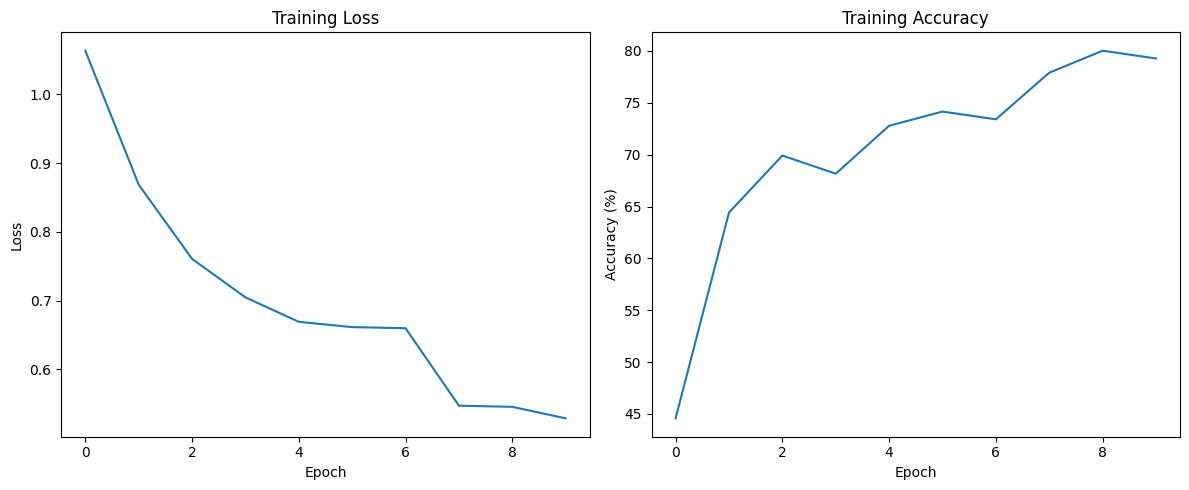

Model saved to custom_image_classifier_model.pth


In [ ]:
# Cell 9: Train the model or load a previously trained model
model_save_path = "custom_image_classifier_model.pth"

if os.path.exists(model_save_path):
    print(f"Loading existing model from {model_save_path}")
    model.load_state_dict(torch.load(model_save_path, map_location=device))
else:
    print("Training new model...")
    model, history = train_model(model, train_loader, num_epochs=10)

    # Plot training metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'])
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

    # Save the model
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

Model Evaluation Metrics:
Accuracy: 0.7612
Precision: 0.7637
Recall: 0.7612
F1 Score: 0.7614


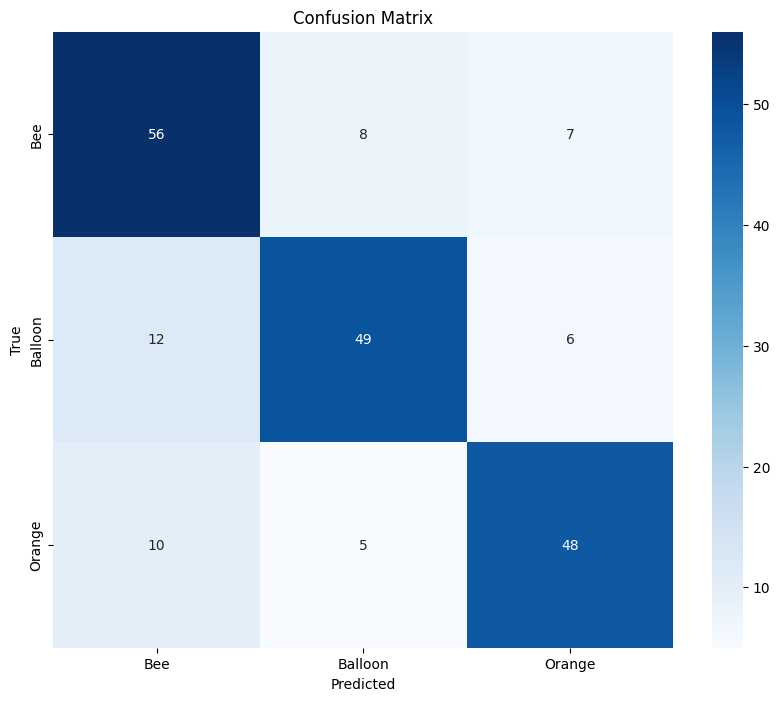


Per-class metrics:
Class: Bee
  Precision: 0.7179
  Recall: 0.7887
  F1 Score: 0.7517
Class: Balloon
  Precision: 0.7903
  Recall: 0.7313
  F1 Score: 0.7597
Class: Orange
  Precision: 0.7869
  Recall: 0.7619
  F1 Score: 0.7742


In [ ]:
# Cell 10: Evaluate model performance
def evaluate_model(model, test_loader):
    model.eval()

    all_labels = []
    all_predictions = []
    all_features = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Extract features and get predictions
            outputs = model(inputs)
            all_features.append(model.features.cpu().numpy())

            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_features = np.vstack(all_features)

    # Calculate metrics
    cm = confusion_matrix(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print("Model Evaluation Metrics:")
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate per-class metrics
    print("\nPer-class metrics:")
    precision_per_class = precision_score(all_labels, all_predictions, average=None)
    recall_per_class = recall_score(all_labels, all_predictions, average=None)
    f1_per_class = f1_score(all_labels, all_predictions, average=None)

    for i, class_name in enumerate(classes):
        print(f"Class: {class_name}")
        print(f"  Precision: {precision_per_class[i]:.4f}")
        print(f"  Recall: {recall_per_class[i]:.4f}")
        print(f"  F1 Score: {f1_per_class[i]:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'features': all_features,
        'labels': all_labels
    }

# Run evaluation
eval_results = evaluate_model(model, test_loader)


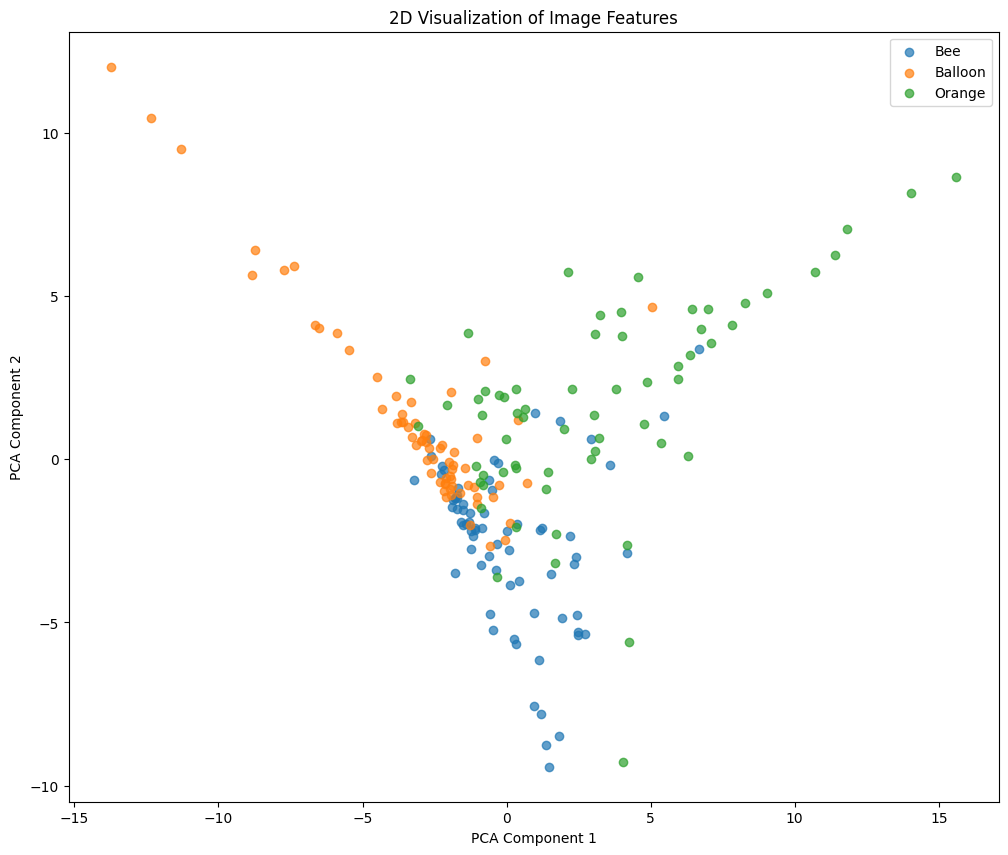

In [ ]:
# Cell 11: Set up similarity search using extracted features
def setup_similarity_search(features, labels):
    # Reduce dimensionality for visualization
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)

    # Set up nearest neighbors search
    nn = NearestNeighbors(n_neighbors=5)
    nn.fit(features)

    # Plot the 2D visualization
    plt.figure(figsize=(12, 10))
    for i, class_name in enumerate(classes):
        mask = labels == i
        plt.scatter(features_2d[mask, 0], features_2d[mask, 1], label=class_name, alpha=0.7)

    plt.legend()
    plt.title('2D Visualization of Image Features')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

    return nn, features

# Set up similarity search
nn_model, all_features = setup_similarity_search(eval_results['features'], eval_results['labels'])
all_labels = eval_results['labels']

In [ ]:
# Cell 12: Function to find similar images
def find_similar_images(query_feature, nn_model, features, labels, k=5):
    distances, indices = nn_model.kneighbors([query_feature], n_neighbors=k)
    similar_labels = labels[indices[0]]
    return distances[0], indices[0], similar_labels

In [ ]:
# Cell 12: Function to find similar images
def find_similar_images(query_feature, nn_model, features, labels, k=5):
    distances, indices = nn_model.kneighbors([query_feature], n_neighbors=k)
    similar_labels = labels[indices[0]]
    return distances[0], indices[0], similar_labels

# Cell 13: Function to predict class and find similar images for a new image
def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Get the predicted class
    predicted_class = classes[predicted.item()]
    class_probabilities = probabilities[0].cpu().numpy()

    # Get features for similarity search
    features_np = model.features.cpu().numpy()[0]

    # Find similar images
    distances, indices, similar_labels = find_similar_images(features_np, nn_model, all_features, all_labels)

    # Display the results
    plt.figure(figsize=(14, 7))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')

    # Plot the probability chart
    plt.subplot(1, 2, 2)
    bars = plt.bar(classes, class_probabilities * 100)

    # Color the highest probability bar
    max_idx = np.argmax(class_probabilities)
    for i, bar in enumerate(bars):
        if i == max_idx:
            bar.set_color('red')

    plt.title('Classification Probabilities')
    plt.ylabel('Probability (%)')
    plt.ylim(0, 100)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print similarity results
    print("\nSimilar images:")
    for i in range(len(indices)):
        print(f"#{i+1}: Class: {classes[similar_labels[i]]}, Similarity: {1-distances[i]:.4f}")

    return predicted_class, class_probabilities, features_np

In [ ]:
# Cell 14: Testing with a sample image (replace 'sample_image.jpg' with your own image path)
# Uncomment and run this to test with your own image
# predicted_class, probabilities, features = predict_image('sample_image.jpg')

In [ ]:
# Cell 15: Create a REST API using Flask for deployment

"""
This is how you would create a REST API for your model.
You would typically put this in a separate file and run it as a standalone app.
"""

from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict_api():
    if 'image' not in request.files:
        return jsonify({'error': 'No image provided'}), 400

    file = request.files['image']
    img = Image.open(file.stream).convert('RGB')

    # Preprocess the image
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Convert to python types for JSON
    class_idx = predicted.item()
    probs = probabilities[0].cpu().numpy().tolist()

    # Get features for similarity search
    features_np = model.features.cpu().numpy()[0]

    # Find similar images
    distances, indices, similar_labels = find_similar_images(features_np, nn_model, all_features, all_labels)

    # Create similarity results
    similarity_results = []
    for i in range(len(indices)):
        similarity_results.append({
            'index': int(indices[i]),
            'distance': float(distances[i]),
            'class': classes[int(similar_labels[i])]
        })

    # Create response
    response = {
        'class': classes[class_idx],
        'class_id': int(class_idx),
        'probabilities': {classes[i]: float(probs[i]) for i in range(len(classes))},
        'similar_images': similarity_results
    }

    return jsonify(response)

if __name__ == "__main__":
    app.run(host='0.0.0.0', port=5000, debug=False)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
# Cell 16: Create a simple widget for image classification in Jupyter
from ipywidgets import FileUpload, Button, Output, Label, HBox, VBox
import io

# Create widgets
upload_widget = FileUpload(accept='image/*', multiple=False, description='Select Image')
predict_button = Button(description='Classify')
result_label = Label('Upload an image and click "Classify"')
output = Output()

# Layout
widget_box = VBox([
    Label('Image Classification'),
    upload_widget,
    predict_button,
    result_label,
    output
])

# Callback function
def on_predict_button_clicked(b):
    if not upload_widget.value:
        result_label.value = "Please upload an image first"
        return

    # Clear previous output
    with output:
        output.clear_output()

    # Get the image
    uploaded_file = next(iter(upload_widget.value.values()))
    content = uploaded_file['content']

    # Convert to image
    image = Image.open(io.BytesIO(content)).convert('RGB')

    with output:
        # Make prediction
        try:
            image_tensor = transform(image).unsqueeze(0).to(device)

            model.eval()
            with torch.no_grad():
                outputs = model(image_tensor)
                _, predicted = torch.max(outputs, 1)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)

            predicted_class = classes[predicted.item()]
            class_probabilities = probabilities[0].cpu().numpy()

            # Get features for similarity search
            features_np = model.features.cpu().numpy()[0]

            # Find similar images
            distances, indices, similar_labels = find_similar_images(features_np, nn_model, all_features, all_labels)

            # Display the result
            result_label.value = f"Predicted: {predicted_class} with {class_probabilities[predicted.item()]*100:.2f}% confidence"

            # Display the image and probabilities
            plt.figure(figsize=(14, 7))

            # Display the image
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title(f'Predicted: {predicted_class}')
            plt.axis('off')

            # Plot the probability chart
            plt.subplot(1, 2, 2)
            bars = plt.bar(classes, class_probabilities * 100)

            max_idx = np.argmax(class_probabilities)
            for i, bar in enumerate(bars):
                if i == max_idx:
                    bar.set_color('red')

            plt.title('Classification Probabilities')
            plt.ylabel('Probability (%)')
            plt.ylim(0, 100)

            # Add value labels on top of bars
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{height:.1f}%', ha='center', va='bottom')

            plt.tight_layout()
            plt.show()

            # Print similarity results
            print("\nSimilar images:")
            for i in range(len(indices)):
                print(f"#{i+1}: Class: {classes[similar_labels[i]]}, Similarity: {1-distances[i]:.4f}")

        except Exception as e:
            result_label.value = f"Error during classification: {str(e)}"
            print(f"Error: {str(e)}")

# Connect callback
predict_button.on_click(on_predict_button_clicked)

# Display the widget interface
display(widget_box)